In [1]:
import scanpy as sc
import numpy as np
import anndata as ad

import random
import torch
import sklearn
import os
import pandas as pd

In [8]:
def plot_ndreamer(dataset_name, cell_type_key, batch_key, condition_key):
    print("adata preprocessing...")

    import warnings
    warnings.filterwarnings("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)

    adata = sc.read_h5ad("./" + dataset_name + "/adata.h5ad")
    adata.raw = None

    if batch_key is None:
        batch_key=condition_key
    if isinstance(batch_key, str):
        batch_key = [batch_key]

    batch_all = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all.append(tmp)
    batch_all = np.array(batch_all)
    adata.obs["batch_all"] = batch_all
    adata.obs["batch_all"] = adata.obs["batch_all"].astype("category")
    print("batch_all", np.unique(batch_all))

    batch_all_with_condition = []
    for i in range(adata.shape[0]):
        tmp = "__".join([adata.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + str(adata.obs[condition_key][i])
        batch_all_with_condition.append(tmp)
    batch_all_with_condition = np.array(batch_all_with_condition)
    adata.obs["batch_all_with_condition"] = batch_all_with_condition
    adata.obs["batch_all_with_condition"] = adata.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition", np.unique(batch_all_with_condition))

    main_effect_adata = ad.AnnData(adata.obsm['X_effect_modifier_space_PCA'], dtype=np.float32)
    main_effect_adata.obs = adata.obs.copy()

    integrated = []
    for filei in os.listdir("./" + dataset_name):
        if filei.find("expression.h5ad") > 0:
            integrated.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    integrated = ad.concat(integrated, merge="same", uns_merge="same")

    # Process `batch_all` for denoised data
    batch_all_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all_denoise.append(tmp)
    batch_all_denoise = np.array(batch_all_denoise)
    integrated.obs["batch_all"] = batch_all_denoise
    integrated.obs["batch_all"] = integrated.obs["batch_all"].astype("category")
    print("batch_all_denoise", np.unique(batch_all_denoise))

    # Process `batch_all_with_condition` for denoised data
    batch_all_with_condition_denoise = []
    for i in range(integrated.shape[0]):
        tmp = "__".join([integrated.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + str(integrated.obs[condition_key][i])
        batch_all_with_condition_denoise.append(tmp)
    batch_all_with_condition_denoise = np.array(batch_all_with_condition_denoise)
    integrated.obs["batch_all_with_condition"] = batch_all_with_condition_denoise
    integrated.obs["batch_all_with_condition"] = integrated.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition_denoise", np.unique(batch_all_with_condition_denoise))

    # Handle `ITE` files
    ITE = []
    for filei in os.listdir("./" + dataset_name):
        if filei.find("ITE.h5ad") > 0:
            ITE.append(sc.read_h5ad("./" + dataset_name + "/" + filei))
    ITE = ad.concat(ITE, merge="same", uns_merge="same")

    # Process `batch_all` for ITE data
    batch_all_ite = []
    for i in range(ITE.shape[0]):
        tmp = "__".join([ITE.obs[batch_keyj][i] for batch_keyj in batch_key])
        batch_all_ite.append(tmp)
    batch_all_ite = np.array(batch_all_ite)
    ITE.obs["batch_all"] = batch_all_ite
    ITE.obs["batch_all"] = ITE.obs["batch_all"].astype("category")
    print("batch_all_ite", np.unique(batch_all_ite))

    # Process `batch_all_with_condition` for ITE data
    batch_all_with_condition_ite = []
    for i in range(ITE.shape[0]):
        tmp = "__".join([ITE.obs[batch_keyj][i] for batch_keyj in batch_key])
        tmp = tmp + "__" + str(ITE.obs[condition_key][i])
        batch_all_with_condition_ite.append(tmp)
    batch_all_with_condition_ite = np.array(batch_all_with_condition_ite)
    ITE.obs["batch_all_with_condition"] = batch_all_with_condition_ite
    ITE.obs["batch_all_with_condition"] = ITE.obs["batch_all_with_condition"].astype("category")
    print("batch_all_with_condition_ite", np.unique(batch_all_with_condition_ite))

    batch_key.append("batch_all")
    batch_key.append("batch_all_with_condition")
    print("Finish preprocess")

    print("Plot of main effect:")
    if main_effect_adata.shape[1] > 60:
        sc.pp.pca(main_effect_adata)
    else:
        main_effect_adata.obsm['X_pca'] = main_effect_adata.X.copy()
    sc.pp.neighbors(main_effect_adata, n_neighbors=15)
    sc.tl.umap(main_effect_adata)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(main_effect_adata, color=colori, ncols=1)

    print("Plot of denoised expression")
    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15)
    sc.tl.umap(integrated)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(integrated, color=colori, ncols=1)

    print("Plot of ITE")
    sc.pp.pca(ITE)
    sc.pp.neighbors(ITE, n_neighbors=15)
    sc.tl.umap(ITE)
    for colori in [cell_type_key, condition_key] + batch_key:
        sc.pl.umap(ITE, color=colori, ncols=1)

    print("Within each unique condition, plot main effect")
    unique_conditions = np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Now evaluating", conditioni, "main effect")
        main_effect_adatai = main_effect_adata[main_effect_adata.obs[condition_key] == conditioni]
        for colori in [cell_type_key] + batch_key:
            sc.pl.umap(main_effect_adatai, color=colori, ncols=1)
        print("-"*20)

    print("Within each unique condition, plot denoised expression")
    unique_conditions = np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Now evaluating", conditioni, "denoised expression")
        integratedi = integrated[integrated.obs[condition_key] == conditioni]
        for colori in [cell_type_key] + batch_key:
            sc.pl.umap(integratedi, color=colori, ncols=1)
        print("-" * 20)

    print("Within each unique condition, plot ITE")
    unique_conditions = np.unique(np.array(integrated.obs[condition_key]))
    for conditioni in unique_conditions:
        print("Now evaluating", conditioni, "ITE")
        if np.sum(ITE.obs[condition_key] == conditioni)==0:
            continue
        ITEi = ITE[ITE.obs[condition_key] == conditioni]
        for colori in [cell_type_key] + batch_key:
            sc.pl.umap(ITEi, color=colori, ncols=1)
        print("-" * 20)

adata preprocessing...
batch_all ['10291856' '10383017' '11259716' '11469504' '11619606' '11632851'
 '11681508' '12365619' '15413198' '15483818' '20151388' '20399274'
 '20584923' '20646778' '20780035' '20906079' '21001771' '21171080'
 '21272396' '31509843' '37030589' '37178462' '41773404' '50105301'
 '50106280' '50109639' '50301125' '50400709' '50403446' '50410319'
 '61827429' '62404688' '65652206' '66754397' '67429065' '68539908'
 '70625336' '70816595' '76733461' '77891596' '78452313' '82317494'
 '83034844' '86934089' '90780976' '91444029' '94430339' '98953007']
batch_all_with_condition ['10291856__0' '10383017__0' '11259716__0' '11469504__0' '11619606__1'
 '11632851__0' '11681508__0' '12365619__1' '15413198__0' '15483818__0'
 '20151388__1' '20399274__0' '20584923__0' '20646778__0' '20780035__1'
 '20906079__1' '21001771__0' '21171080__1' '21272396__0' '31509843__0'
 '37030589__0' '37178462__0' '41773404__0' '50105301__0' '50106280__0'
 '50109639__0' '50301125__0' '50400709__1' '504034

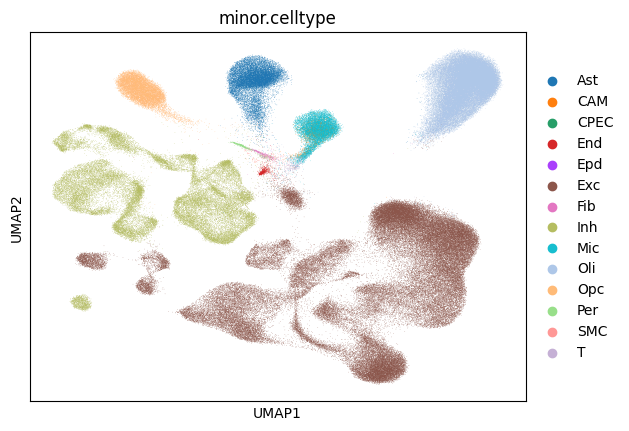

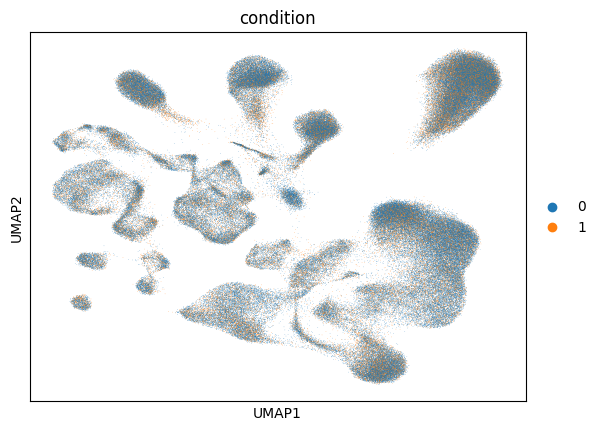

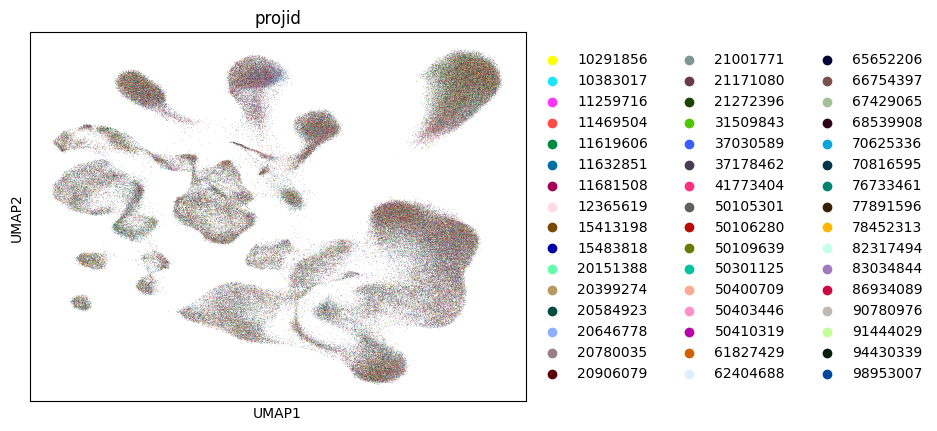

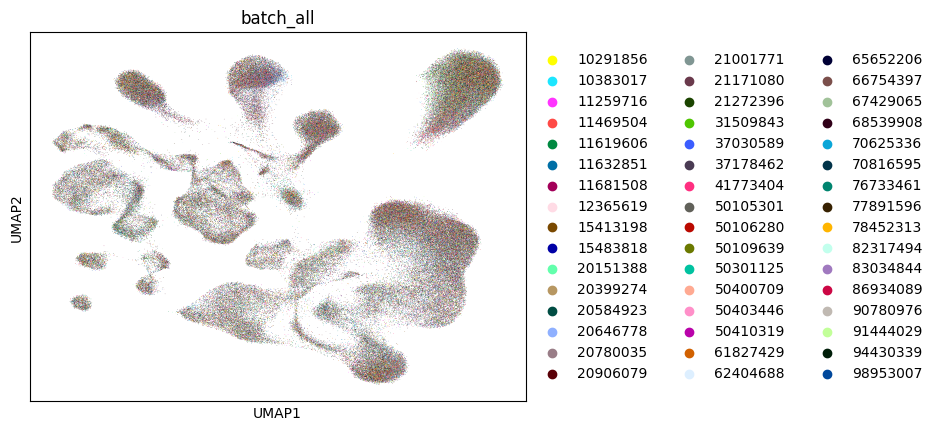

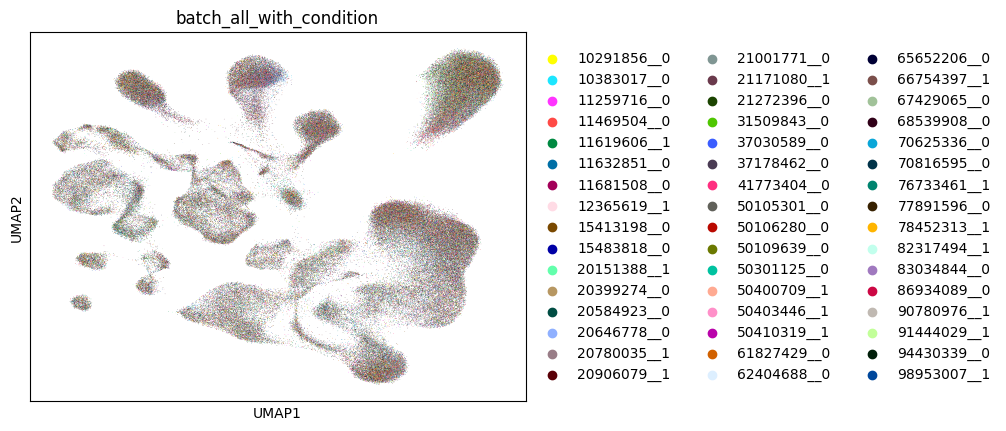

Plot of denoised expression


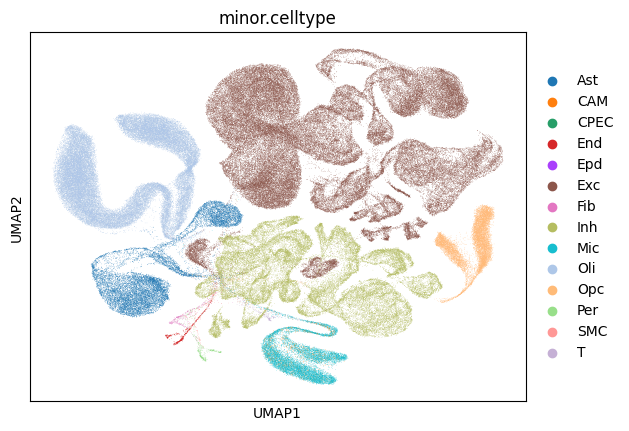

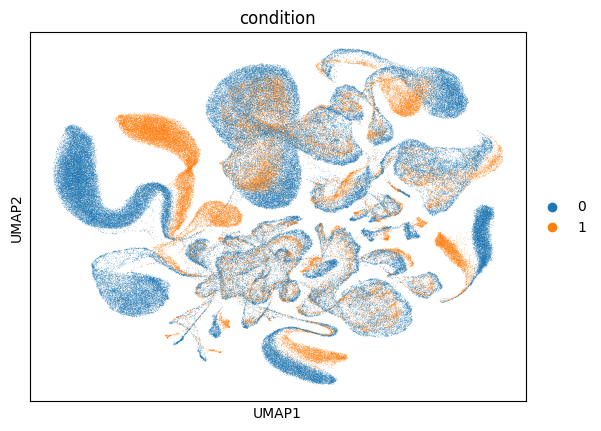

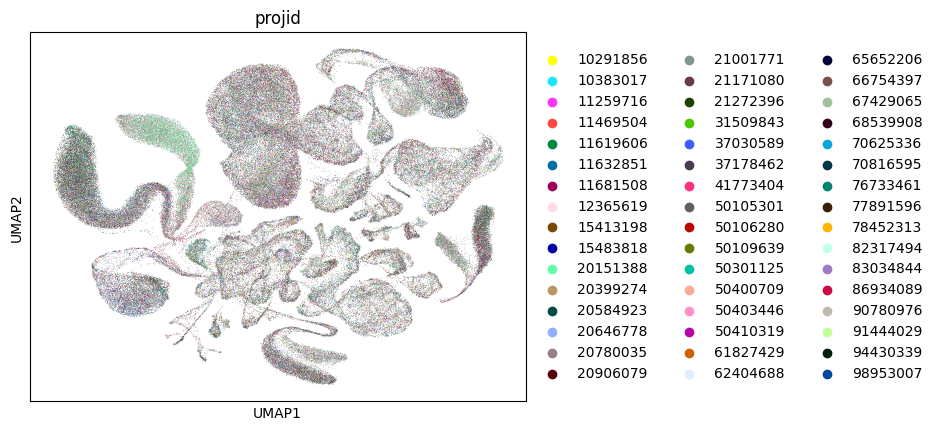

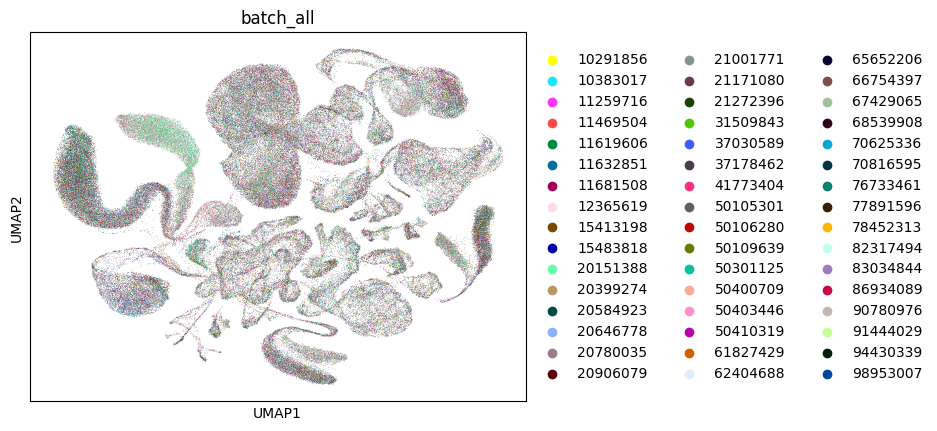

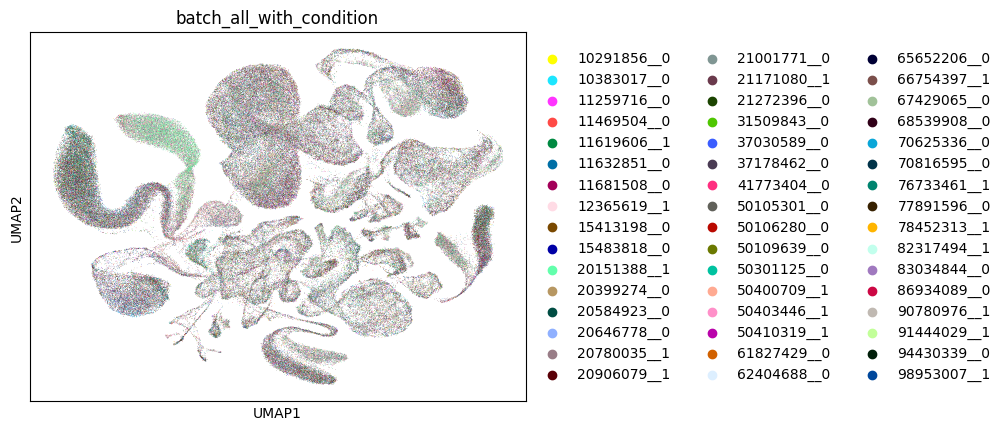

Plot of ITE


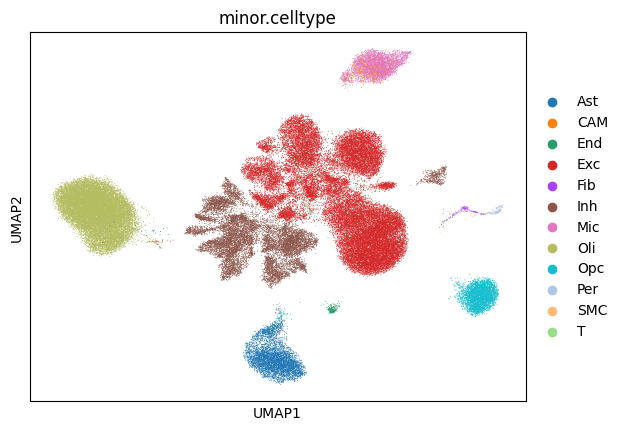

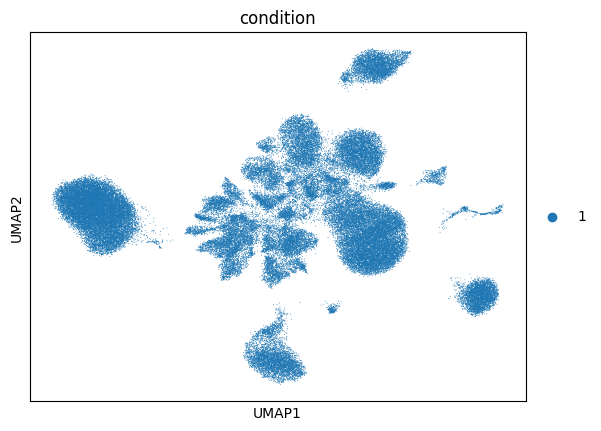

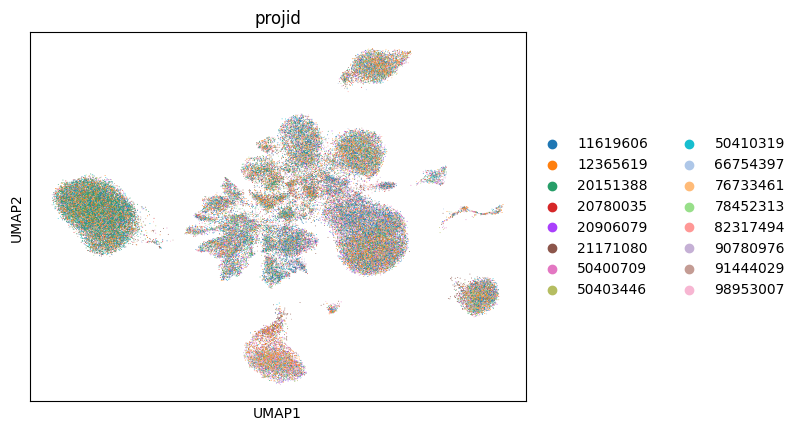

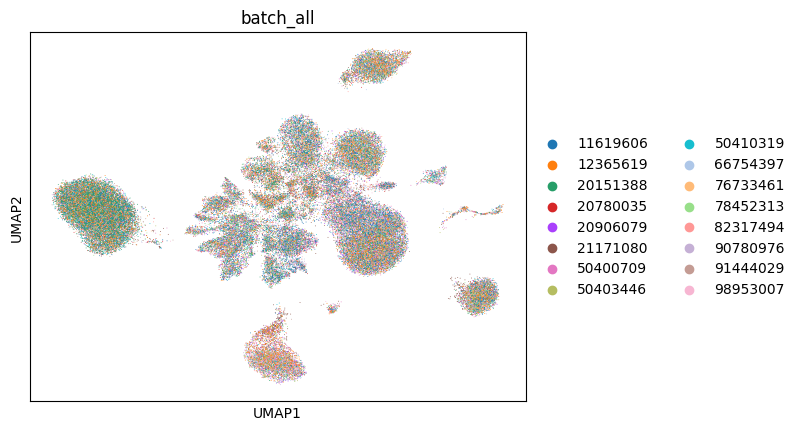

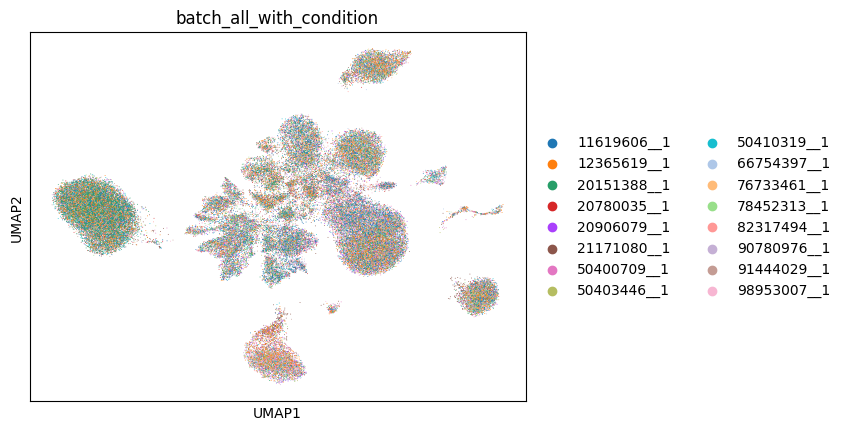

Within each unique condition, plot main effect
Now evaluating 0 main effect


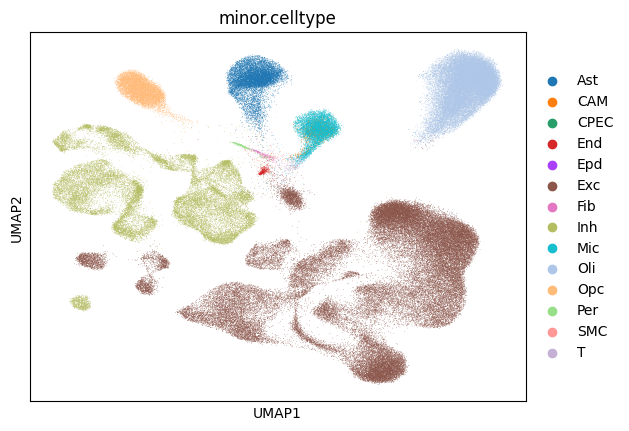

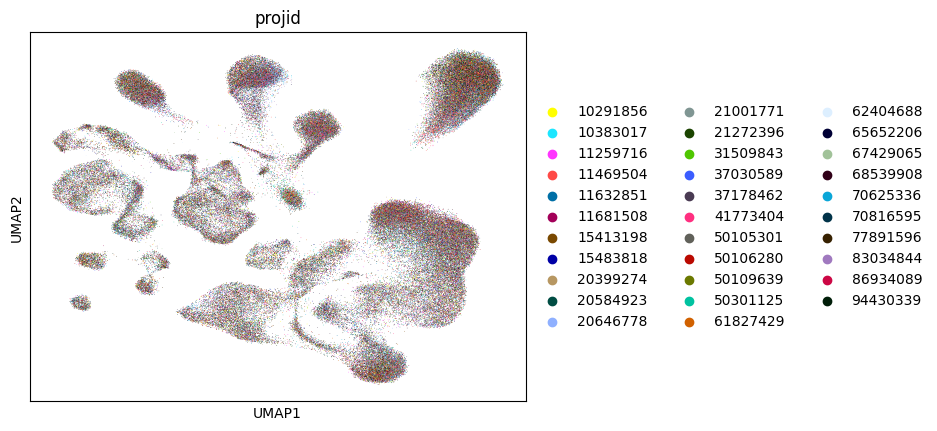

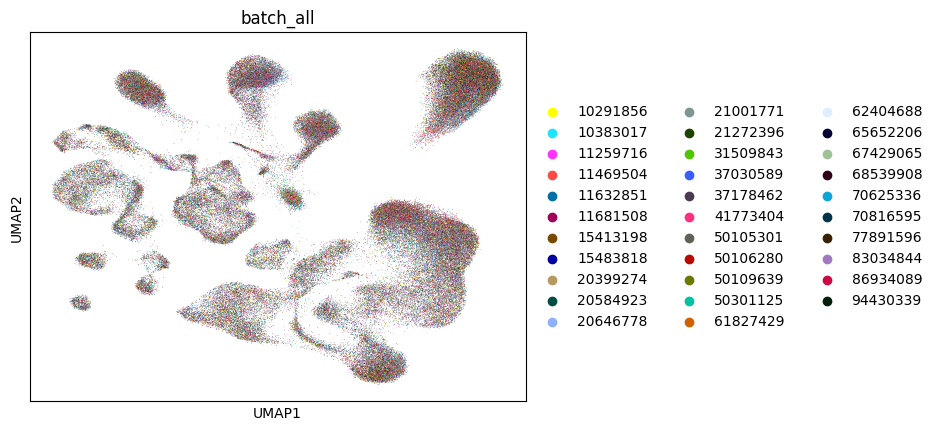

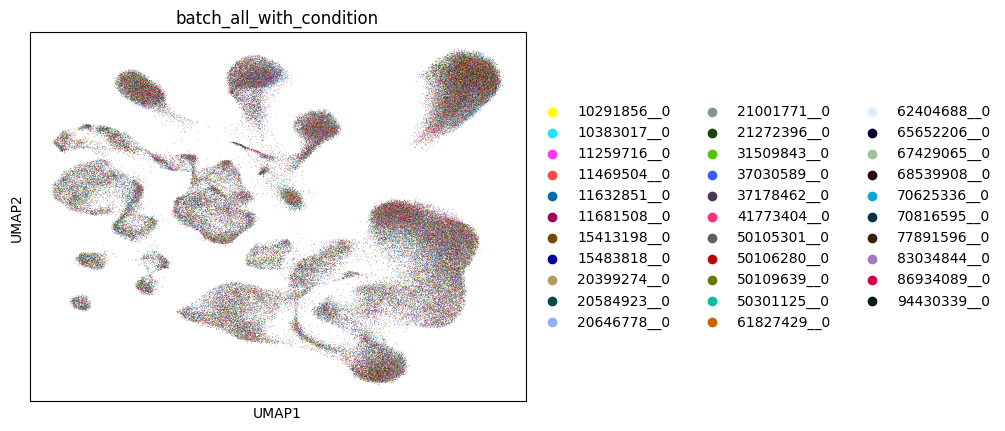

--------------------
Now evaluating 1 main effect


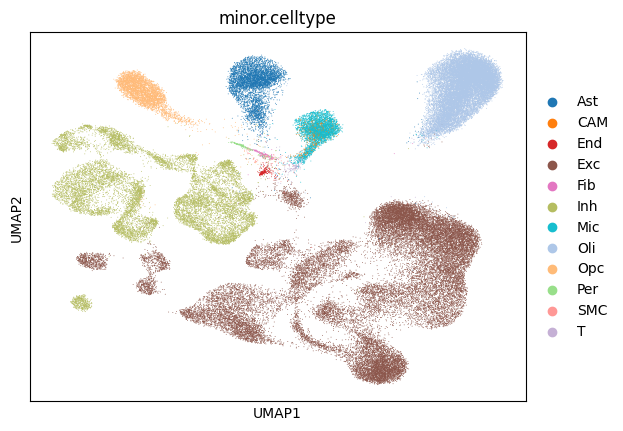

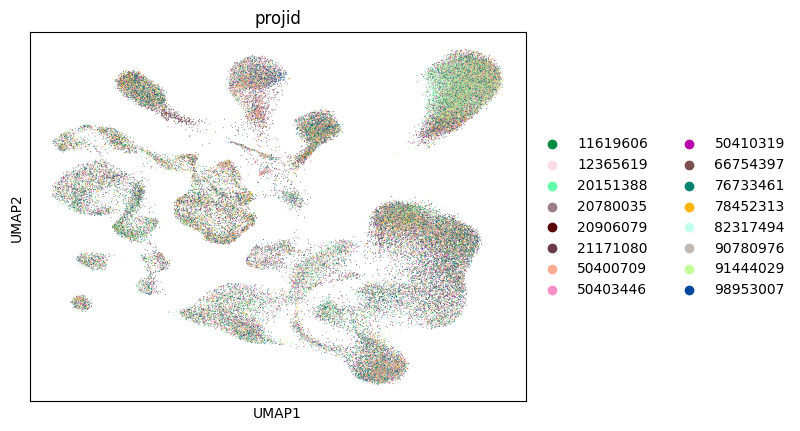

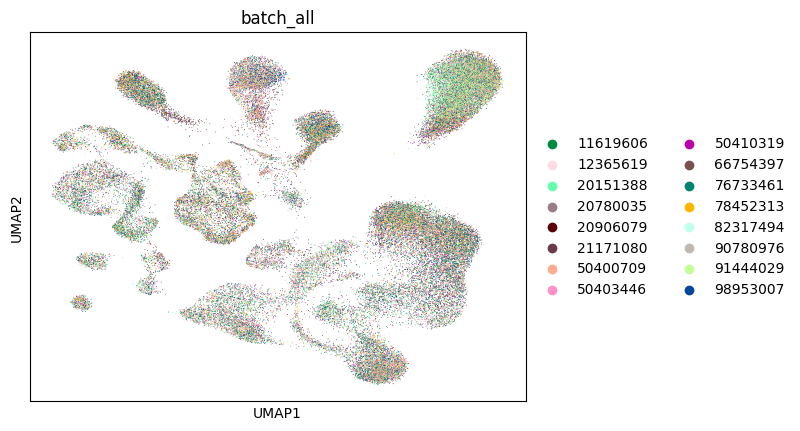

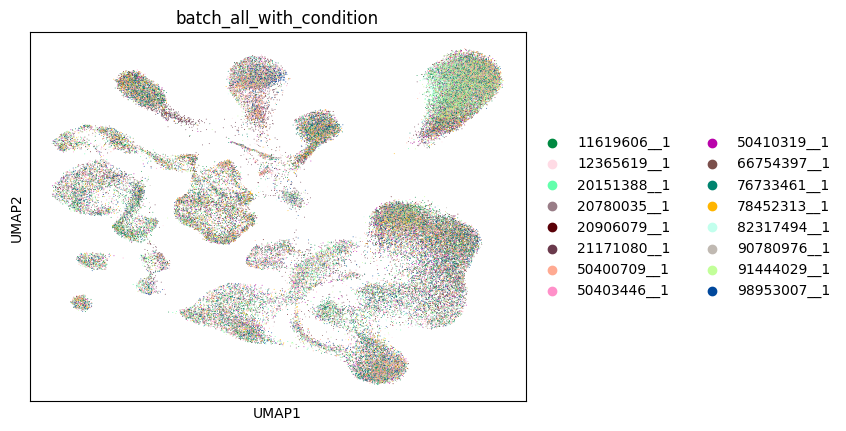

--------------------
Within each unique condition, plot denoised expression
Now evaluating 0 denoised expression


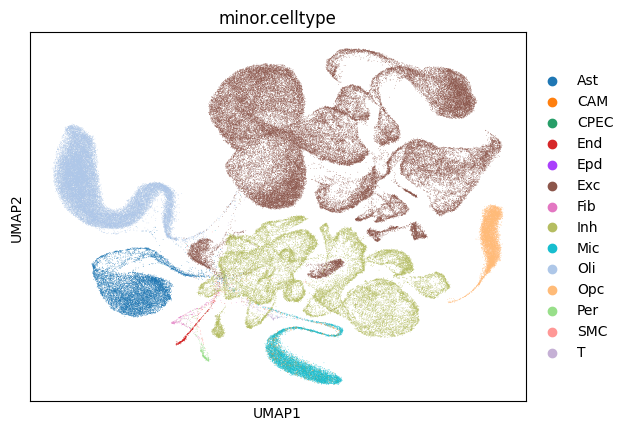

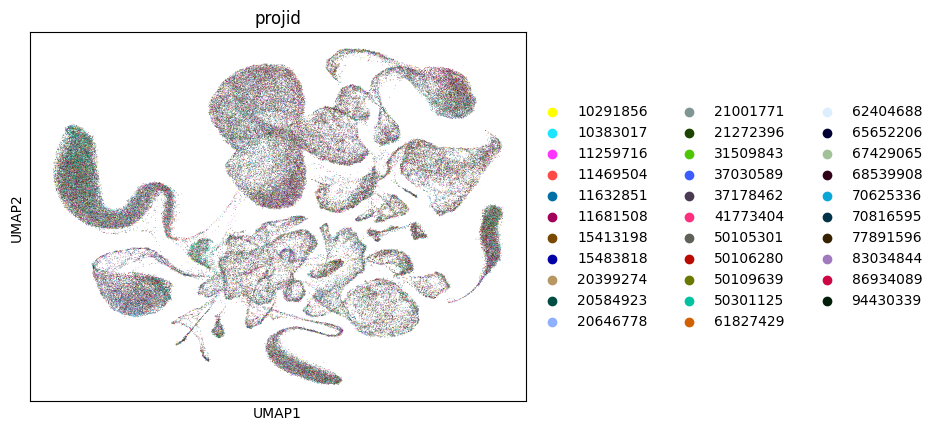

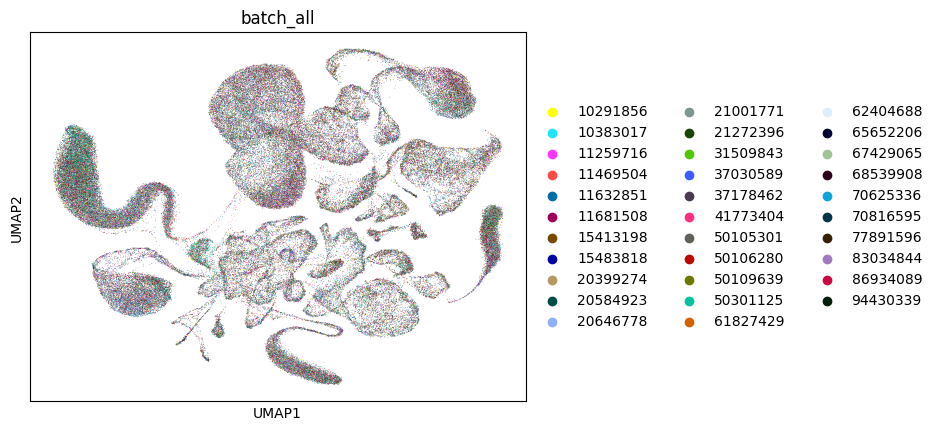

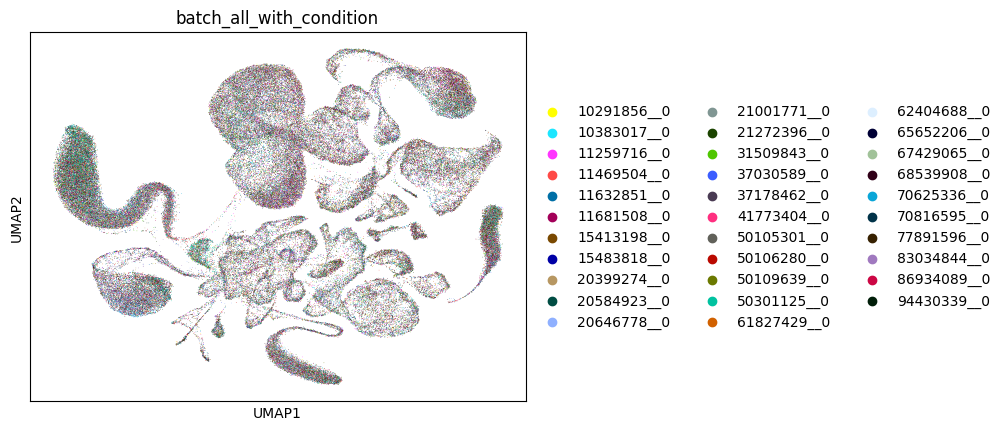

--------------------
Now evaluating 1 denoised expression


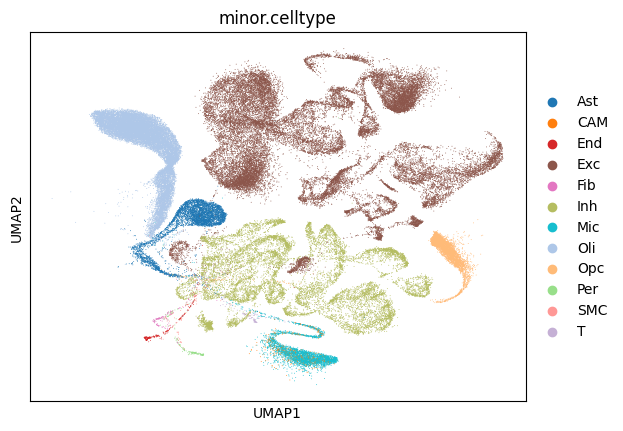

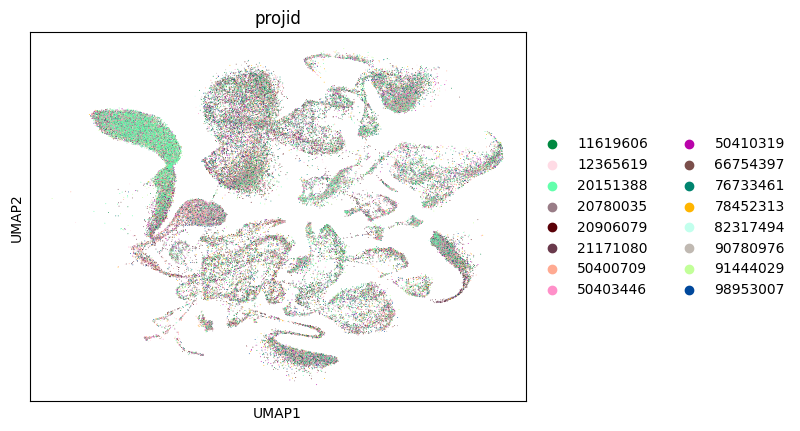

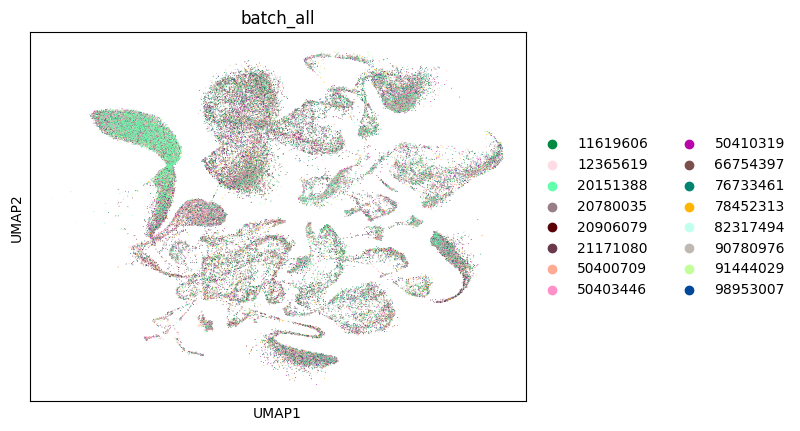

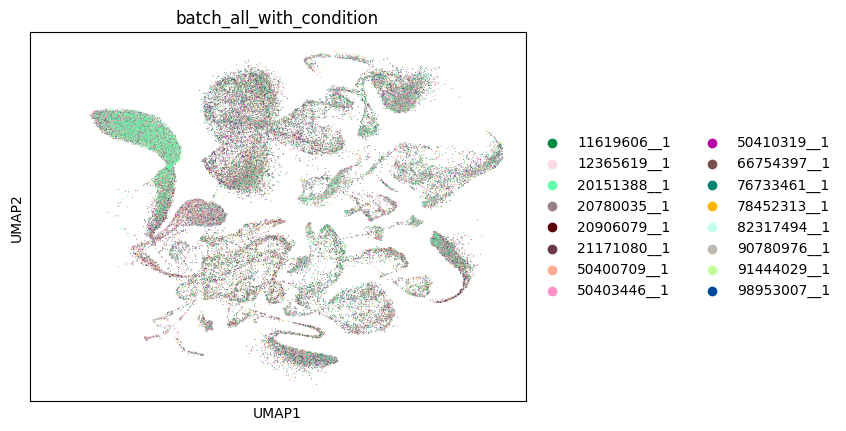

--------------------
Within each unique condition, plot ITE
Now evaluating 0 ITE
Now evaluating 1 ITE


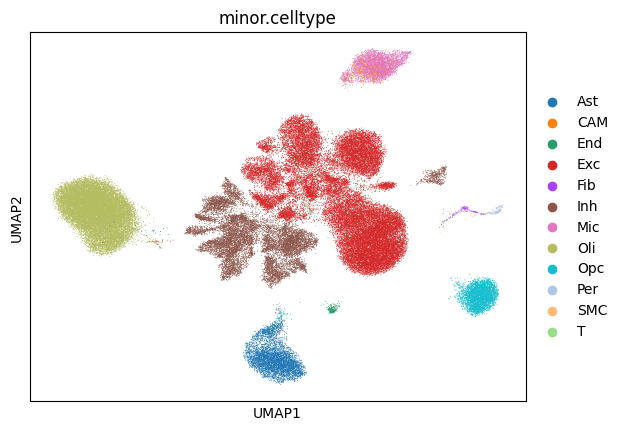

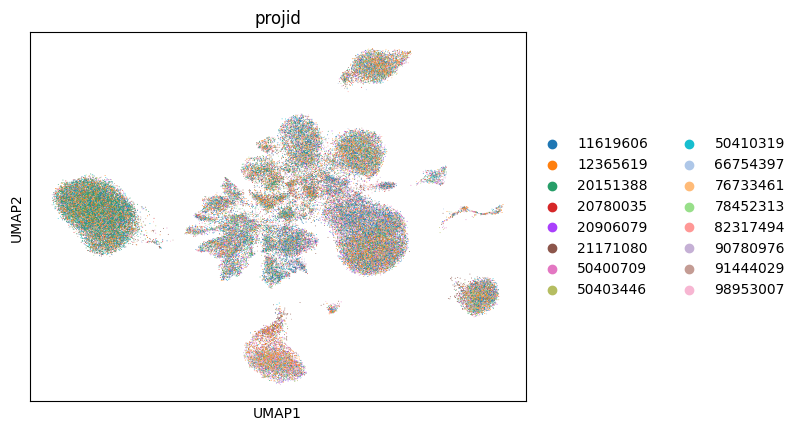

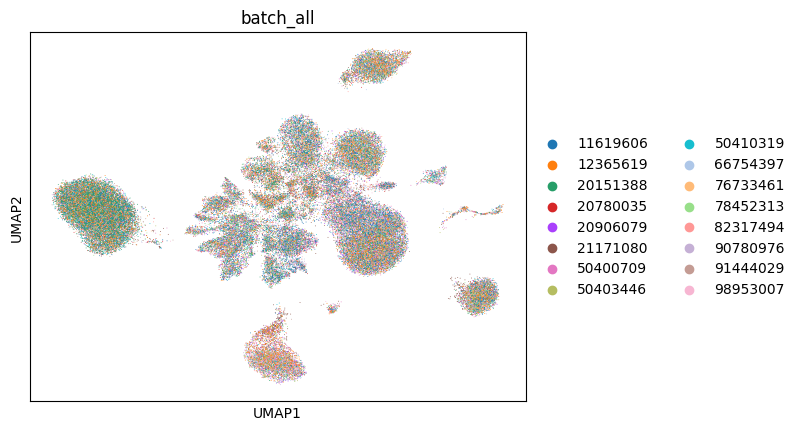

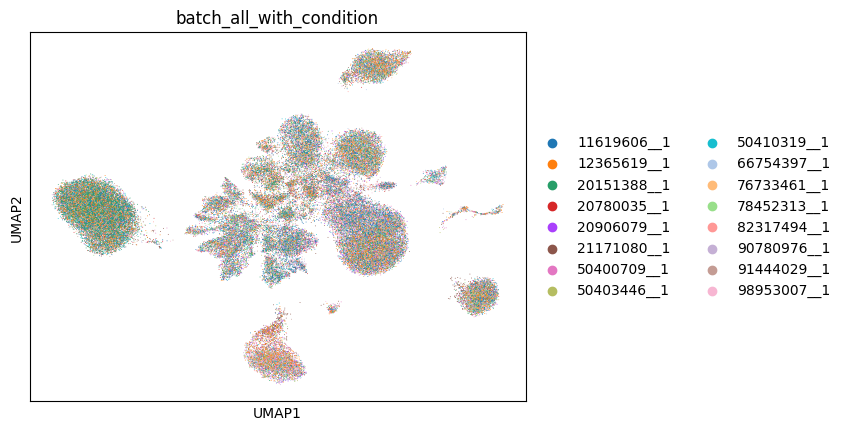

--------------------


In [9]:
plot_ndreamer(dataset_name="ROSMAP",cell_type_key="minor.celltype",batch_key="projid",condition_key="condition")